# Sentiment Analysis - Creation of a Sentiment Lexicon

Notebook for slides.

Shows how to load data, preprocess it, create DTMs from text, weight words to be used for correlations and final sentiment words.

## Preparatory

In [ ]:
# download data from https://ai.stanford.edu/~amaas/data/sentiment/
! wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
! tar xvfz aclImdb_v1.tar.gz

In [ ]:
# python stuff
%%bash

# activate environment (python or conda)
python3 -m venv venv
source venv/bin/activate

#pip install jupyter
pip install numpy pandas scipy scikit-learn matplotlib
pip install nltk spacy

python -m spacy download en_core_web_sm
python -m spacy download de_core_news_sm

---

In [1]:
import pickle
from pathlib import Path

import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
# from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
from IPython.display import display_html

## Workflow (Data &rarr; Results)

In [2]:
paths = ["train/neg", "train/pos"]
datafile = Path("docs.p")


def load_contents(paths):
    docs = dict()  # doc-id -> score + content

    for path in paths:
        for file in tqdm(Path(path).iterdir()):
            id = file.stem
            score = int(id.rsplit("_", 1)[-1])
            content = file.read_text()
            docs[id] = (score, content)

    print(f"Loaded {len(docs)} files")


In [3]:
def process(nlp, content):
    content = content.replace("<br />", "")
    doc = nlp(content)
    tokens = [
        w.text
        for w in doc
        if (
            # no stopwords
            not w.is_stop
            # no digits
            and w.is_alpha
            # no spaces, punctuation, ...
            and w.pos_ not in ("PUNCT", )  # ?
            and not w.is_space
        )
    ]
    doc = " ".join(tokens)
    return doc


def process_docs(nlp, docs):
    return {
        id: (score, process(nlp, content))
        for id, (score, content) in tqdm(docs.items())
    }

In [4]:
def compute_dtm(docs, tfidf=True):
    scores, texts = zip(*docs.values())
    if tfidf:
        vectorizer = TfidfVectorizer(max_features=5000)  #, use_idf=False, binary=True)
    else:
        vectorizer = CountVectorizer()
    mat = vectorizer.fit_transform(texts)

    return mat, scores, vectorizer


def truncate(mat, scores, cutoff = 6000):
    scores = np.array(scores)
    idx = np.random.permutation(np.arange(scores.shape[0]))[:cutoff]

    scores = scores[idx]
    mat = np.asarray(mat[idx].todense())
    assert mat.shape[0] == scores.shape[0]

    return mat, scores

In [5]:
def get_best_features_both(values, labels, max_features=30):
    # filter nan
    mask = ~np.isnan(values)
    labels = labels[mask]
    values = values[mask]

    # have both the highest and lowest
    # so mask with both ends allowed, and our values+labels sorted
    mask = np.zeros_like(values).astype(bool)
    mask[: max_features // 2 + 1] = mask[-max_features // 2 :] = True
    srt = np.argsort(values)[::-1]
    labels = np.array(labels)[srt][mask]
    values = np.array(values)[srt][mask]

    # srt = np.argsort(np.abs(values))[::-1]
    # #np.unique(mask, return_counts=True)
    # mask_srt = mask[srt]
    # mask_srt[max_features:] = False

    # labels_srt = np.array(labels)[srt][mask_srt]
    # values_srt = np.array(values)[srt][mask_srt]

    # srt = np.argsort(values_srt)[::-1]
    # labels = labels_srt[srt]
    # values = values_srt[srt]

    return pd.Series(values, labels)


def get_best_features(values, labels, max_features=30):
    # filter nan
    mask = ~np.isnan(values)
    labels = labels[mask]
    values = values[mask]

    srt = np.argsort(np.abs(values))[::-1]
    mask = np.ones_like(values).astype(bool)
    mask_srt = mask[srt]
    mask_srt[max_features:] = False
    labels_srt = np.array(labels)[srt][mask_srt]
    values_srt = np.array(values)[srt][mask_srt]

    srt = np.argsort(values_srt)[::-1]
    labels = labels_srt[srt]
    values = values_srt[srt]

    return pd.Series(values, labels)


In [6]:
def dump_example(docs, mat, vectorizer, corr, name="0_9"):
    print(docs[name])

    row_idx = list(docs.keys()).index(name)
    print("-->", row_idx)
    print()

    df_ex1 = pd.Series(mat[row_idx], vectorizer.get_feature_names_out())
    # print(df_ex1[df_ex1 > 0])

    df_ex1 = pd.Series(
        np.asarray((vectorizer.transform([docs[name][1]]).todense()))[0],
        vectorizer.get_feature_names_out())
    df_ex1 = df_ex1[df_ex1 > 0]
    print(", ".join(f"{w}: {v:.3f}" for w, v in df_ex1.to_dict().items()))
    print()

    df_se1 = pd.Series({w: corr[w] for w in df_ex1.to_dict().keys()})
    df_se1_b = get_best_features(df_se1, df_se1.index, 20)
    print(", ".join(f"{w}: {v:.3f}" for w, v in df_se1_b.to_dict().items()))
    print()
    print("sum (sentiment):", df_se1.sum())
    print("sum (sentiment top-20):", df_se1_b.sum())
    print("sum (sentiment product tfidf):", (df_ex1 * df_se1).sum())
    print()

    # display_html(pd.DataFrame([df_ex1]))
    # display_html(pd.DataFrame([df_se1]))
    # display_html(pd.DataFrame([df_ex1 * df_se1]))


### Load data and preprocess

In [16]:
# docs: doc-id -> score + content
docs = load_contents(paths)

25000


<AxesSubplot: >

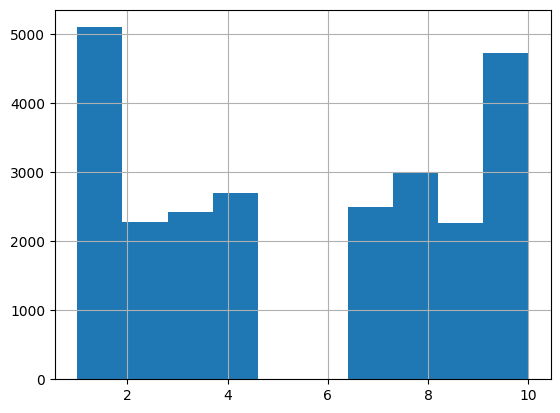

In [22]:
pd.Series([v for v, _ in docs.values()]).hist()

In [25]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
for label in nlp.get_pipe("tagger").labels:
    print(label, " -- ", spacy.explain(label))

In [ ]:
# process(docs[list(docs.keys())[1]][1])
# docs[list(docs.keys())[0]]

In [7]:
# cache spaCy cleaning (~20min)

if not datafile.exists():
    docs = process_docs(nlp, docs)

    with open(datafile, "wb") as fp:
        pickle.dump(docs, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open(datafile, "rb") as fp:
    docs = pickle.load(fp)

### Compute DTM (+ truncate)

mat shape: (16000, 5000)
features shape: (5000,)
scores shape: (16000,)
mat min/max: 0.0 0.9674103507850611


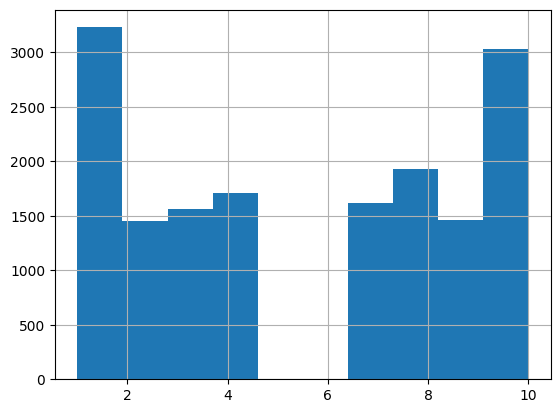

In [8]:
mat, scores, vectorizer = compute_dtm(docs)

mat, scores = truncate(mat, scores, 16000)

pd.Series(scores).hist()

print("mat shape:", mat.shape)
print("features shape:", vectorizer.get_feature_names_out().shape)
print("scores shape:", scores.shape)

# mat[:,0].shape
# rows --> docs (+ scores)
# cols --> types

print("mat min/max:", mat.min(), mat.max())

### Compute Correlations

In [9]:
df_mat = pd.DataFrame(mat, columns=vectorizer.get_feature_names_out())
df_scores = pd.Series(scores)

# pearson / kendall / spearman
corr = df_mat.corrwith(df_scores, method="pearson")
#corr2 = df_mat.corrwith(df_scores / 10, method="pearson")
corr_kt = df_mat.corrwith(df_scores, method="kendall")
corr_sr = df_mat.corrwith(df_scores, method="spearman")

In [10]:
pd.DataFrame([corr, corr_kt, corr_sr], index=["pearson", "kendall", "spearman"]).T.corr()

,pearson,kendall,spearman
pearson,1.000000,0.987287,0.987334
kendall,0.987287,1.000000,0.999891
spearman,0.987334,0.999891,1.000000


In [11]:
plt.rcParams["figure.figsize"]  # [6.4, 4.8]
plt.rcParams["figure.figsize"] = [3, 5]

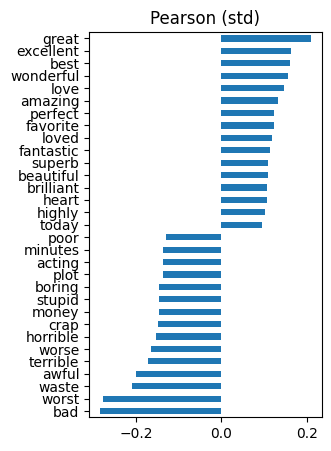

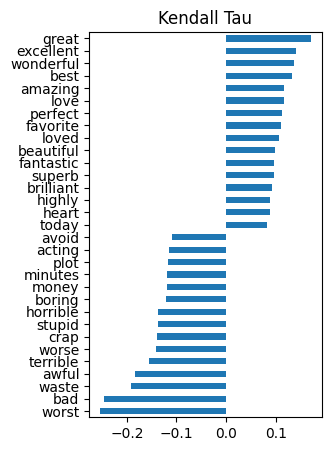

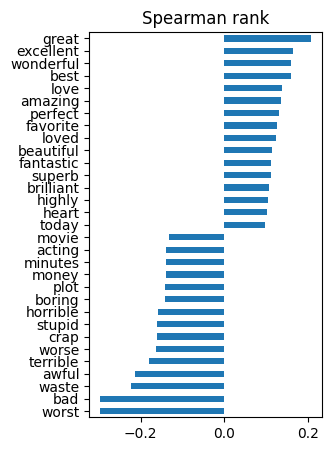

In [12]:
# corr2 = corr / (corr.max() - corr.min()) * 2
# scale differently between -1 / 0 / +1

get_best_features_both(corr, corr.index, 30)[::-1].plot(kind="barh")
plt.title("Pearson (std)")
plt.show()
get_best_features_both(corr_kt, corr_kt.index)[::-1].plot(kind="barh")
plt.title("Kendall Tau")
plt.show()
get_best_features_both(corr_sr, corr_sr.index)[::-1].plot(kind="barh")
plt.title("Spearman rank")
plt.show()

---

### Some Examples

In [142]:
dump_example(docs, mat, vectorizer, corr, "0_9")
#dump_example(docs, mat, vectorizer, corr, "2_9")
#dump_example(docs, mat, vectorizer, corr, "1_1")

(9, 'Bromwell High cartoon comedy ran time programs school life Teachers years teaching profession lead believe Bromwell High satire closer reality Teachers scramble survive financially insightful students right pathetic teachers pomp pettiness situation remind schools knew students saw episode student repeatedly tried burn school immediately recalled High classic line INSPECTOR sack teachers STUDENT Welcome Bromwell High expect adults age think Bromwell High far fetched pity')
--> 12765

adults: 0.113, age: 0.091, believe: 0.073, burn: 0.134, cartoon: 0.111, classic: 0.081, closer: 0.125, comedy: 0.072, episode: 0.090, expect: 0.089, far: 0.070, fetched: 0.139, high: 0.384, immediately: 0.108, inspector: 0.137, knew: 0.094, lead: 0.086, life: 0.057, line: 0.080, pathetic: 0.108, pity: 0.122, ran: 0.122, reality: 0.095, remind: 0.130, repeatedly: 0.135, right: 0.068, satire: 0.123, saw: 0.068, school: 0.170, situation: 0.101, student: 0.226, students: 0.234, survive: 0.120, teachers: 0

---

## Toy Example

Raw input texts


,sentiment,text
toy1,10,Ein richtig tolles Spiel.
toy2,1,Ganz schlechte Leistung.
toy3,9,Sehr leckeres Gericht. Zu empfehlen.
toy4,2,Ganz schlechtes Spiel. Nicht zu empfehlen.


100%|██████████| 4/4 [00:00<00:00, 128.33it/s]

spaCy cleaned texts


,sentiment,text
toy1,10,tolles Spiel
toy2,1,schlechte Leistung
toy3,9,leckeres Gericht empfehlen
toy4,2,schlechtes Spiel empfehlen


DTM (TF/counts) with scores


,empfehlen,gericht,leckeres,leistung,schlechte,schlechtes,spiel,tolles,sentiment
0,0,0,0,0,0,0,1,1,10
1,0,0,0,1,1,0,0,0,1
2,1,1,1,0,0,0,0,0,9
3,1,0,0,0,0,1,1,0,2


DTM (TF-IDF) with scores


,empfehlen,gericht,leckeres,leistung,schlechte,schlechtes,spiel,tolles
0,0.00,0.00,0.00,0.00,0.00,0.00,0.62,0.79
1,0.00,0.00,0.00,0.71,0.71,0.00,0.00,0.00
2,0.49,0.62,0.62,0.00,0.00,0.00,0.00,0.00
3,0.53,0.00,0.00,0.00,0.00,0.67,0.53,0.00


,empfehlen,gericht,leckeres,leistung,schlechte,schlechtes,spiel,tolles,sentiment
0,0.00,0.00,0.00,0.00,0.00,0.00,0.62,0.79,10
1,0.00,0.00,0.00,0.71,0.71,0.00,0.00,0.00,1
2,0.49,0.62,0.62,0.00,0.00,0.00,0.00,0.00,9
3,0.53,0.00,0.00,0.00,0.00,0.67,0.53,0.00,2


Correlations


,empfehlen,gericht,leckeres,leistung,schlechte,schlechtes,spiel,tolles
0,-0.033768,0.50128,0.50128,-0.644503,-0.644503,-0.50128,0.203028,0.644503


,0
empfehlen,-0.033768
gericht,0.501280
leckeres,0.501280
leistung,-0.644503
schlechte,-0.644503
schlechtes,-0.501280
spiel,0.203028
tolles,0.644503


'Sentiments' for top words


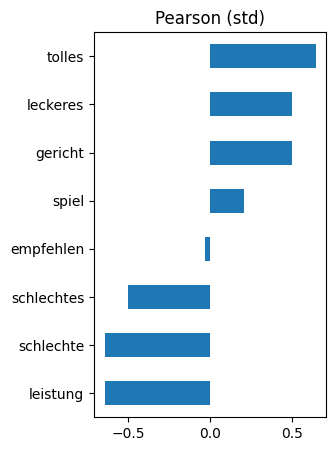

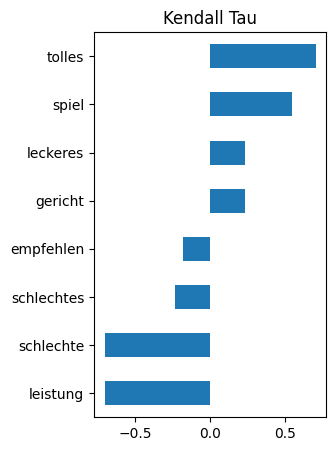

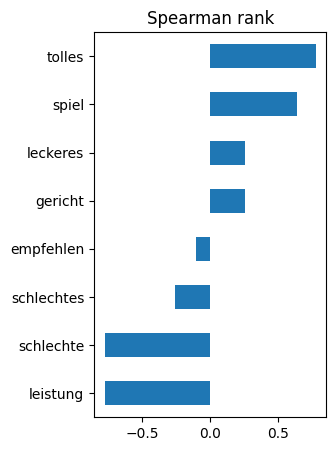

In [147]:
docs_toy = {
    "toy1": (10, "Ein richtig tolles Spiel."),
    "toy2": (1, "Ganz schlechte Leistung."),
    "toy3": (9, "Sehr leckeres Gericht. Zu empfehlen."),
    "toy4": (2, "Ganz schlechtes Spiel. Nicht zu empfehlen."),
}

print("Raw input texts")
display_html(pd.DataFrame(docs_toy.values(), index=list(docs_toy.keys()), columns=["sentiment", "text"]))

nlp_toy = spacy.load("de_core_news_sm")
docs_toy = process_docs(nlp_toy, docs_toy)

print("spaCy cleaned texts")
display_html(pd.DataFrame(docs_toy.values(), index=list(docs_toy.keys()), columns=["sentiment", "text"]))

mat_toy, scores_toy, vectorizer_toy = compute_dtm(docs_toy, tfidf=False)
print("DTM (TF/counts) with scores")
display_html(pd.concat([
    pd.DataFrame(np.asarray(mat_toy.todense()), columns=vectorizer_toy.get_feature_names_out()),
    pd.DataFrame(pd.Series(np.array(scores_toy)), columns=["sentiment"])
    ], axis=1))

print("DTM (TF-IDF) with scores")
mat_toy, scores_toy, vectorizer_toy = compute_dtm(docs_toy)
scores_toy = np.array(scores_toy)
mat_toy = np.asarray(mat_toy.todense())

# pd.Series(scores_toy).hist()
# plt.title("Scores histogram")
# plt.show()

# print("mat shape:", mat_toy.shape)
# print("features shape:", vectorizer_toy.get_feature_names_out().shape)
# print("scores shape:", scores_toy.shape)
# print("mat min/max:", mat_toy.min(), mat_toy.max())

df_mat_toy = pd.DataFrame(mat_toy, columns=vectorizer_toy.get_feature_names_out())
df_scores_toy = pd.Series(scores_toy)

display_html(df_mat_toy.round(2))
display_html(pd.concat([df_mat_toy.round(2), pd.DataFrame(df_scores_toy, columns=["sentiment"])], axis=1))

# pearson / kendall / spearman
corr_toy = df_mat_toy.corrwith(df_scores_toy, method="pearson")
corr_toy_kt = df_mat_toy.corrwith(df_scores_toy, method="kendall")
corr_toy_sr = df_mat_toy.corrwith(df_scores_toy, method="spearman")

print("Correlations")
display_html(pd.DataFrame([pd.Series(corr_toy)]))
display_html(pd.DataFrame([pd.Series(corr_toy)]).T)

print("'Sentiments' for top words")
get_best_features_both(corr_toy, corr_toy.index, 30)[::-1].plot(kind="barh")
plt.title("Pearson (std)")
plt.show()
get_best_features_both(corr_toy_kt, corr_toy_kt.index)[::-1].plot(kind="barh")
plt.title("Kendall Tau")
plt.show()
get_best_features_both(corr_toy_sr, corr_toy_sr.index)[::-1].plot(kind="barh")
plt.title("Spearman rank")
plt.show()